In [2]:
# IMPORT PyEMMA
import pyemma
pyemma.__version__


# IMPORT GENERAL PACKAGES
import numpy as np
from IPython import get_ipython
get_ipython().run_line_magic('pylab','')
import pyemma.coordinates as coor
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
trajfile = 'JIP1_Clust_All.nc'
topfile = 'JIP1.prmtop'

feat = coor.featurizer(topfile)

feat.add_backbone_torsions(cossin=True)
feat.describe()[:10]

inp = coor.source(trajfile, feat)
print ('trajectory length = ',inp.trajectory_length(0))
print ('number of dimension = ',inp.dimension())

trajectory length =  130808
number of dimension =  36


In [7]:
# TIME-LAGGED INDEPENDENT COMPONENT ANALYSIS (TICA)
lag=100
tica_obj = coor.tica(inp, lag=lag, var_cutoff=0.95, kinetic_map=False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
tica_output = tica_obj.get_output()

print ('Projected data shape = ',Y.shape)

Projected data shape =  (130808, 10)


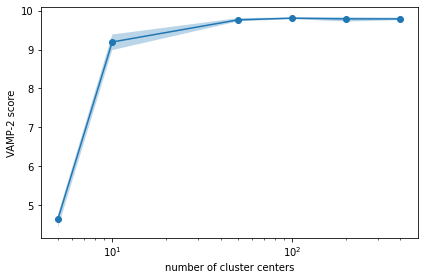

In [8]:
from pyemma.util.contexts import named_temporary_file
n_clustercenters = [5, 10, 50, 100, 200, 400]
scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()
fig.savefig('RMSD_JIP1__vamp_cluster_lag_100_dim10.pdf', bbox_inches='tight')

Retained dimension:  10


Text(0, 0.5, 'Cum. kinetic variance fraction')

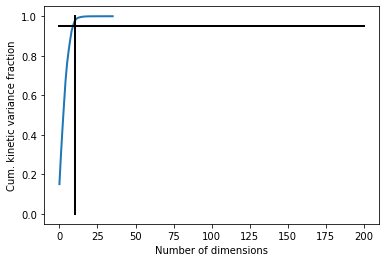

In [9]:
print ('Retained dimension: ', tica_obj.dimension())
plot(tica_obj.cumvar, linewidth=2)
plot([tica_obj.dimension(), tica_obj.dimension()], [0, 1], color='black', linewidth=2)
plot([0, 200], [0.95, 0.95], color='black', linewidth=2)
xlabel('Number of dimensions'); ylabel('Cum. kinetic variance fraction')
# http://www.emma-project.org/v2.0.3/generated/trypsin_benzamidine_hmm.html

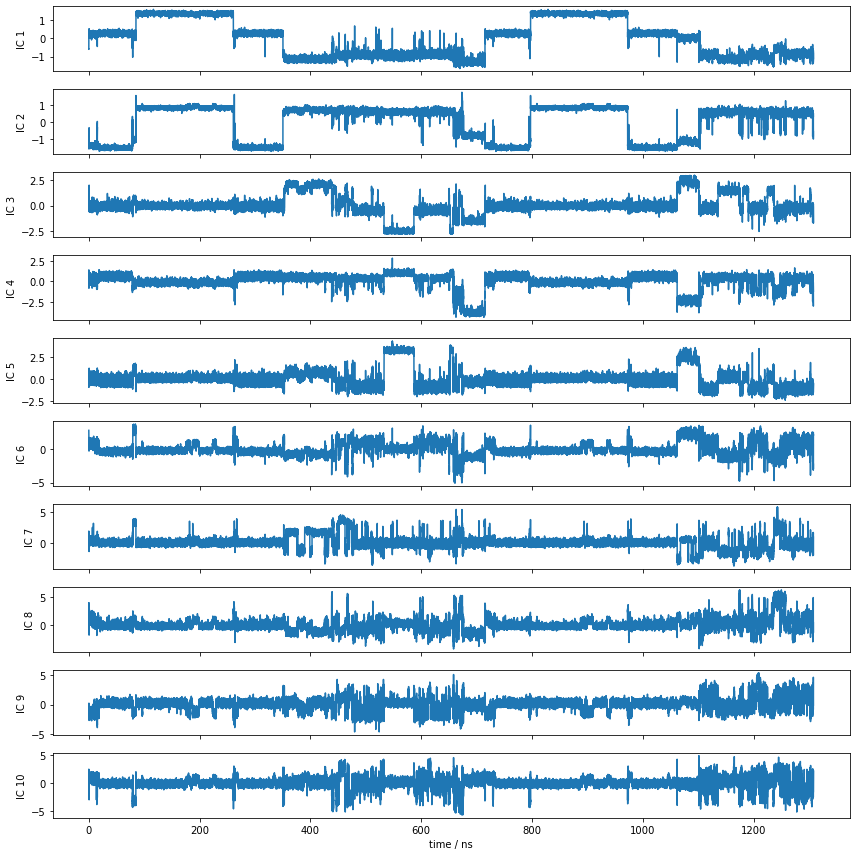

In [10]:
fig, axes = plt.subplots(10, 1, figsize=(12, 12), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x/10, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
fig.savefig('RMSD_JIP1__TICAs_lag_100_dim10.pdf', bbox_inches='tight')
fig.savefig('RMSD_JIP1__TICAs_lag_100_dim10.png', bbox_inches='tight')

In [11]:
print (-lag/np.log(tica_obj.eigenvalues[:10]))


[7078.24500045 3848.34674767 1301.63447652  866.91362753  723.86861634
  349.31281679  224.17164686  190.73673698  173.29065825  117.37995932]


In [12]:
tica_obj.eigenvalues[:10]

array([0.98597153, 0.97434953, 0.92605052, 0.89105267, 0.87097098,
       0.75105503, 0.64012824, 0.59197975, 0.561544  , 0.42658903])

In [13]:
#we use k-means clustering and get the discrete trajectories
cl = coor.cluster_kmeans(data=Y, k=250, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

100%|██████████| 250/250 [00:09<00:00, 25.37it/s]                             

kmeans iterations: 100%|██████████| 10/10 [00:29<00:00,  2.31s/it]

26-08-20 17:17:46 pyemma.coordinates.clustering.kmeans.KmeansClustering[125] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.



100%|██████████| 10/10 [00:29<00:00,  2.91s/it]                   


[7078.24500045 3848.34674767 1301.63447652  866.91362753  723.86861634]


C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


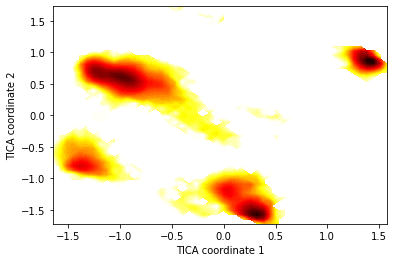

In [14]:
print (-lag/np.log(tica_obj.eigenvalues[:5]))

# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plt.xlabel('TICA coordinate 1'); plt.ylabel('TICA coordinate 2');
#plt.plot(cc_x,cc_y, linewidth=0, marker='o')

plt.show()


In [15]:
# here we do a little trick to ensure that eigenvectors always have the same sign structure.
# That's irrelevant to the analysis and just nicer plots - you can ignore it.
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]                                 


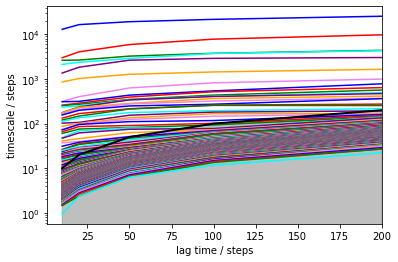

In [16]:
import pyemma.msm as msm
import pyemma.plots as mplt

lags = [10,20,50,100,200]
its = msm.its(dtrajs, lags=lags)

mplt.plot_implied_timescales(its)

100%|██████████| 16/16 [01:05<00:00,  4.07s/it]                        


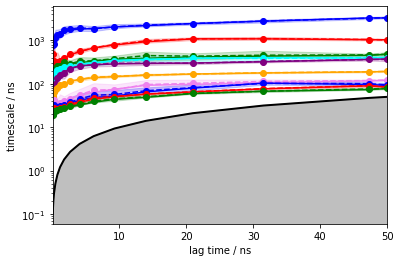

In [17]:
its = pyemma.msm.its(dtrajs, lags=500, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
plt.savefig('RMSD_JIP1_lag_100_dim10.pdf', bbox_inches='tight')

100%|██████████| 100/100 [00:03<00:00, 26.96it/s]                                                                   


fraction of states used =  1.0
fraction of counts used =  1.0


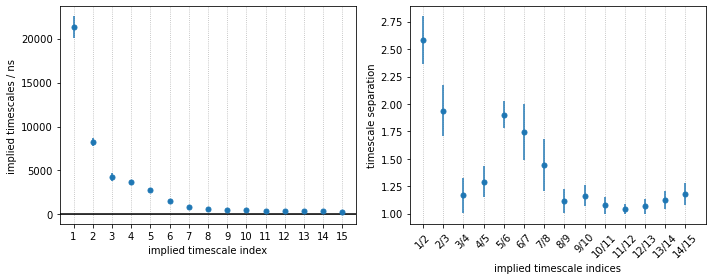

In [19]:


M = msm.bayesian_markov_model(dtrajs, 100)


print ('fraction of states used = ', M.active_state_fraction)
print ('fraction of counts used = ', M.active_count_fraction)

import pyemma.plots as mplt

def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = M.sample_mean('timescales', k=nits)
timescales_std = M.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(M.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, M.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
plt.show()
fig.savefig('BPTI_JIP1_MSM_Ratio_spectral_time_lag_100_cutoff95_k250.pdf', bbox_inches='tight')

100%|██████████| 10/10 [01:05<00:00,  6.53s/it]                        


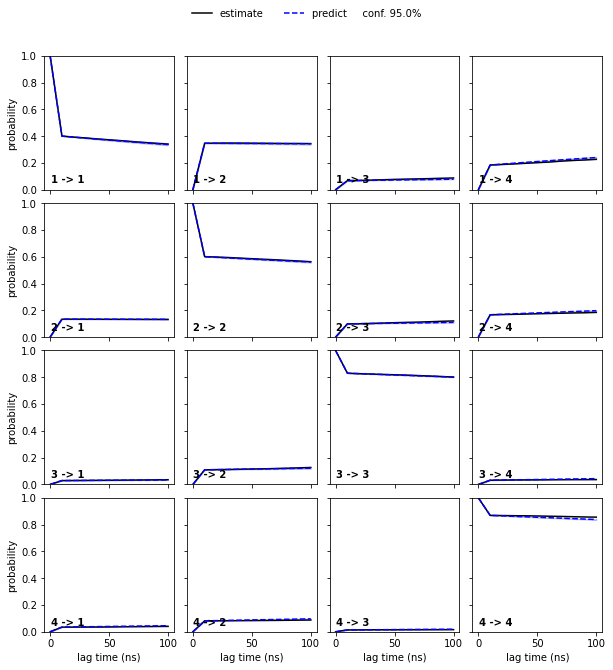

<Figure size 432x288 with 0 Axes>

In [20]:
nstates = 4
cktest = M.cktest(nstates, mlags=11,  err_est=False)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
plt.show()
plt.savefig('cktest_lag_100_k250.pdf', bbox_inches='tight')

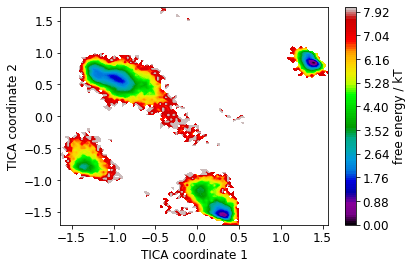

In [21]:
# ... therefore we take the statistical weight of each simulation timestep (also available from the MSM object)
# and use that to create a contour plot
xall = np.vstack(Y)[:,0]
yall = np.vstack(Y)[:,1]
W = np.concatenate(M.trajectory_weights())
# TODO: make this an MSM-weighted free energy plot
matplotlib.rcParams.update({'font.size': 12})
mplt.plot_free_energy(xall, yall)
plt.xlabel('TICA coordinate 1'); plt.ylabel('TICA coordinate 2');

plt.savefig('conformer_energy_weight_lag_100_k250.png', bbox_inches='tight')

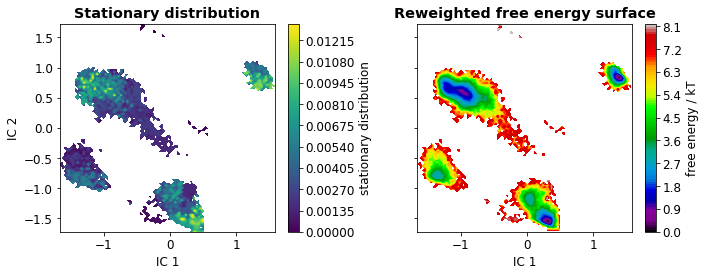

In [23]:
tica_concatenated = np.concatenate(tica_output)
dtrajs_concatenated = np.concatenate(dtrajs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    M.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(M.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

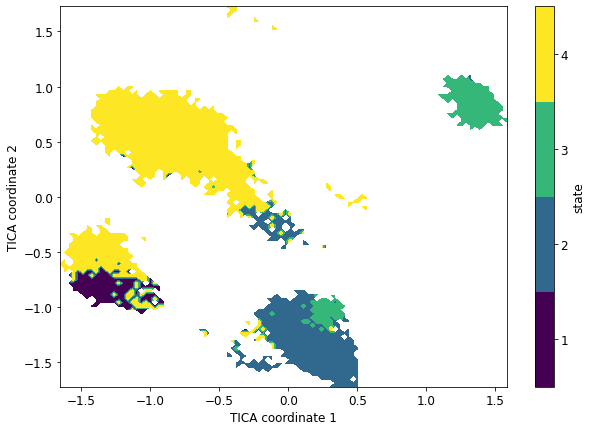

In [25]:
metastable_traj =M.metastable_assignments[dtrajs_concatenated]
highest_membership = M.metastable_distributions.argmax(1)
coarse_state_centers = cl.clustercenters[M.active_set[highest_membership]]


fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax, zorder=-1)
plt.xlabel('TICA coordinate 1'); plt.ylabel('TICA coordinate 2');
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates